# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_error

# CFG

In [39]:
class CFG:
    model_type = 'xgb' # rf or xgb
    
    n_iter = 50 # Iterations of grid search for best model parameters

# Data Preprocessing

In [3]:
df = pd.read_csv('/kaggle/input/sales-prediction-dataset/car_purchasing.csv', encoding='latin1')

In [4]:
df.head()

,customer name,customer e-mail,country,gender,age,annual Salary,credit card debt,net worth,car purchase amount
0,Martina Avila,cubilia.Curae.Phasellus@quisaccumsanconvallis.edu,Bulgaria,0,41.851720,62812.09301,11609.380910,238961.2505,35321.45877
1,Harlan Barnes,eu.dolor@diam.co.uk,Belize,0,40.870623,66646.89292,9572.957136,530973.9078,45115.52566
2,Naomi Rodriquez,vulputate.mauris.sagittis@ametconsectetueradip...,Algeria,1,43.152897,53798.55112,11160.355060,638467.1773,42925.70921
3,Jade Cunningham,malesuada@dignissim.com,Cook Islands,1,58.271369,79370.03798,14426.164850,548599.0524,67422.36313
4,Cedric Leach,felis.ullamcorper.viverra@egetmollislectus.net,Brazil,1,57.313749,59729.15130,5358.712177,560304.0671,55915.46248


In [5]:
df.describe()

,gender,age,annual Salary,credit card debt,net worth,car purchase amount
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.506000,46.241674,62127.239608,9607.645049,431475.713625,44209.799218
std,0.500465,7.978862,11703.378228,3489.187973,173536.756340,10773.178744
min,0.000000,20.000000,20000.000000,100.000000,20000.000000,9000.000000
25%,0.000000,40.949969,54391.977195,7397.515792,299824.195900,37629.896040
50%,1.000000,46.049901,62915.497035,9655.035568,426750.120650,43997.783390
75%,1.000000,51.612263,70117.862005,11798.867487,557324.478725,51254.709517
max,1.000000,70.000000,100000.000000,20000.000000,1000000.000000,80000.000000


## Scatter plot for car purchase amount vs. age

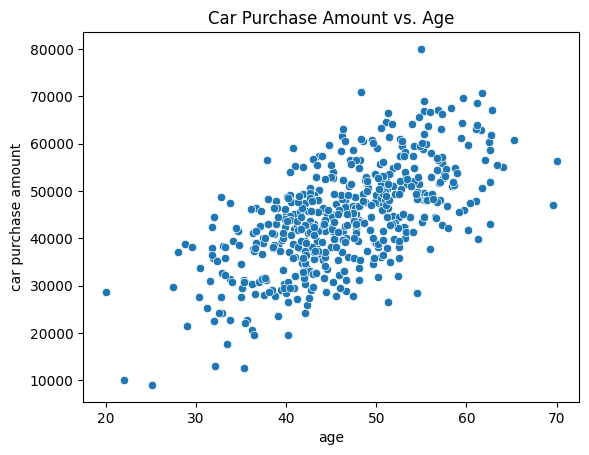

In [6]:
sns.scatterplot(x='age', y='car purchase amount', data=df)
plt.title('Car Purchase Amount vs. Age')
plt.show()

## Boxplot for car purchase amount by gender

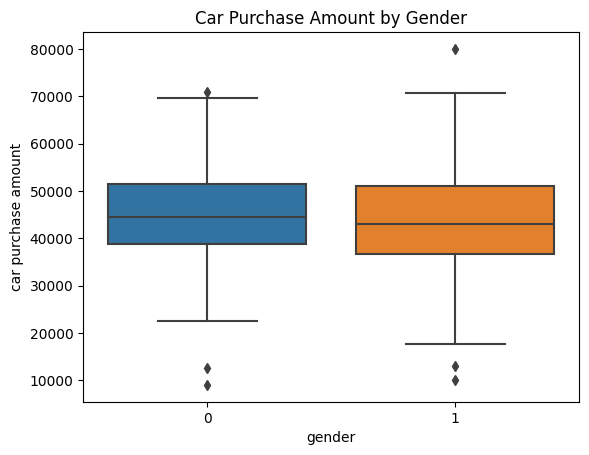

In [7]:
sns.boxplot(x='gender', y='car purchase amount', data=df)
plt.title('Car Purchase Amount by Gender')
plt.show()

## Cross Validation

From previous runs I learned 'credit card debt' doesn't help predictions.

In [40]:
X = df[['age', 'annual Salary', 'net worth']]
y = df['car purchase amount']

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Length of X_train:", len(X_train))
print("Length of X_test:", len(X_test))

Length of X_train: 400
Length of X_test: 100


# Randomized Search On Hyper Parameters 

In [42]:
if CFG.model_type == 'rf':
    param_dist = {
        'n_estimators': [50, 100, 200, 300, 500],
        'max_depth': [10, 20, 30, 50, None],
        'min_samples_split': [2, 5, 10, 15],
        'min_samples_leaf': [1, 2, 4, 6, 8],
        'max_features': [None, 'sqrt', 'log2', 0.2, 0.5],
        'bootstrap': [True, False],
    }
    tmp_model = RandomForestRegressor()
    
elif CFG.model_type == 'xgb':
    param_dist = {
        'n_estimators': [50, 100, 200, 300, 500],
        'max_depth': [3, 6, 10, None],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'min_child_weight': [1, 3, 5]
    }
    tmp_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    
else:
    raise ValueError("Unsupported model type specified in CFG.model_type.")

random_search = RandomizedSearchCV(
    estimator=tmp_model,
    param_distributions=param_dist,
    n_iter=CFG.n_iter,
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=0
)

random_search.fit(X_train, y_train)

best_params = random_search.best_params_
print(f"Best parameters found: {best_params}")

# Use the best model for predictions
model = random_search.best_estimator_

Best parameters found: {'subsample': 0.6, 'n_estimators': 500, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.2, 'colsample_bytree': 0.6}


# Evaluation

In [43]:
y_pred = model.predict(X_test)

In [44]:
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")

Mean Absolute Error: 734.9298109937502
R-squared: 0.9906059578433433


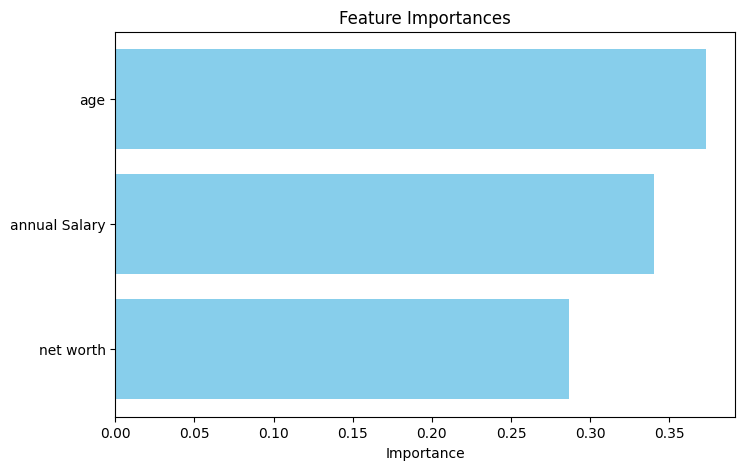

In [45]:
# Get feature names and importances
features = X.columns
importances = model.feature_importances_

# Sort features by importance
sorted_indices = np.argsort(importances)[::-1]
sorted_features = features[sorted_indices]
sorted_importances = importances[sorted_indices]

# Plot the feature importances
plt.figure(figsize=(8, 5))
plt.barh(sorted_features, sorted_importances, color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # To display the highest importance at the top
plt.show()